In [1]:
import os,json
import numpy as np
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D, Conv2D
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
K.set_image_dim_ordering('th')    # channel_first
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    # RGB -> BGR
    return x[:,::-1]

In [3]:
class VGG_16:
    def __init__(self):
        self.FILE_PATH = 'http://files.fast.ai/models/'
        # Create the vgg16 model
        self.model = Sequential()
        self.model.add(Lambda(vgg_preprocess, input_shape=[3,224,224], output_shape=[3,224,224]))
        self.ConvBlock(2, 64)
        self.ConvBlock(2, 128)
        self.ConvBlock(3, 256)
        self.ConvBlock(3, 512)
        self.ConvBlock(3, 512)
        self.model.add(Flatten())
        self.FCBlock(4096)
        self.FCBlock(4096)
        self.FCBlock(1000, False, 'softmax')
        fpath = get_file('vgg16.h5', self.FILE_PATH+'vgg16.h5', cache_subdir='models')
        self.model.load_weights(fpath)
        self.get_imagenet_classes()
        self.classes = self.imagenet_classes
        print('vgg16 parameters loaded!')
    
    def ConvBlock(self,layers, filters):
        for _ in range(layers):
            self.model.add(Conv2D(filters, kernel_size=(3,3), strides=(1, 1), padding='same',activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    def FCBlock(self, units, dropout=True, activation='relu'):
        if dropout:
            self.model.add(Dense(units, activation=activation))
            self.model.add(Dropout(0.5))
        else:
            self.model.add(Dense(units, activation=activation))  
        
    def get_batches(self, path, batch_size,gen=image.ImageDataGenerator(),shuffle=True, class_mode='categorical'):
        return gen.flow_from_directory(path, target_size=(224,224), class_mode=class_mode, batch_size=batch_size, shuffle=shuffle)
    
    def get_imagenet_classes(self):
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.imagenet_classes = [class_dict[str(i)][1] for i in range(len(class_dict))]
    
    def finetune(self, batches, learning_rate=0.001):
        # batches:  A keras.preprocessing.image.DirectoryIterator object
        self.model.pop()
        for layer in self.model.layers:
            layer.trainable = False
        self.FCBlock(batches.num_class, False, 'softmax')
        self.model.compile(optimizer=Adam(lr=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
        classes = list(iter(batches.class_indices))
        for class_name in batches.class_indices:
            classes[batches.class_indices[class_name]] = class_name
        self.classes = classes
    
    def fit(self, train_batches,valid_batches=None, epochs=1):
        steps_per_epoch = train_batches.samples // train_batches.batch_size
        if valid_batches !=None:
            validation_steps = valid_batches.samples // valid_batches.batch_size
        else:
            validation_steps =0
        self.model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, epochs=epochs,
                                 validation_data = valid_batches, validation_steps=validation_steps)

In [4]:
def print_prob(pred, classes, n=5):
    orders = np.argsort(pred)[::-1]
    topN = [(classes[orders[i]], pred[orders[i]]) for i in range(n)]
    for p,s in topN:
        print('prob:{} -> {}'.format(p,s))
    return topN

def show_images(images, imgs_size, pads=(1,1)):
    """
    Show lots of images as one image
    :param images: np.ndaray
    :param imgs_size: A tuple or list of 2 positive integers specifying the number of images shown in two dimensions
    :param pads: A tuple or list of 2 positive integers specifying the padding pixels in two dimensions betwwen images
    :param fig_size: A tuple or list of 2 positive integers specifying the figure size
    """
    if not isinstance(images,np.ndarray):
        images = np.array(images)
    images = images.astype(np.uint8)
    if images.shape[-1] !=1 and  images.shape[-1] !=3:
        images = images.transpose((0,2,3,1))
    axis_x, axis_y = imgs_size
    pad_x, pad_y = pads
    img_shape=images[0].shape
    img_h, img_w, n_channels = img_shape
    show_img=np.zeros([axis_y*(img_h+pad_y), axis_x*(img_w+pad_x), n_channels]).astype(images.dtype)
    for i in range(axis_y):
        for j in range(axis_x):
            show_img[
                i*(img_h+pad_y):i*(img_h+pad_y)+img_h,
                j*(img_w+pad_x):j*(img_w+pad_x)+img_w
            ]=images[i*axis_x+j]
    plt.imshow(show_img)

vgg16 parameters loaded!
Found 3670 images belonging to 5 classes.
prob:sea_anemone -> 0.3620763123035431
prob:skunk -> 0.05306465923786163
prob:feather_boa -> 0.04712741822004318
prob:greenhouse -> 0.0458252839744091
prob:cardoon -> 0.030953049659729004


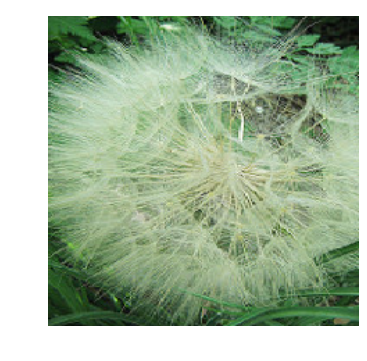

In [5]:
vgg = VGG_16()
batches = vgg.get_batches('data/flower_photos', 16)
test_images, test_labels =next(batches)
preds = vgg.model.predict(test_images)
print_prob(preds[0], vgg.classes)
plt.axis('off')
plt.imshow(test_images[0].transpose((1,2,0)).astype(np.uint8))

In [6]:
vgg.finetune(batches)
print(vgg.classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Epoch 1/1
229/229 [==============================] - 6336s - loss: 1.0848 - acc: 0.7116   


In [10]:
try:
    vgg.fit(batches,epochs=5)
except KeyboardInterrupt:
    print("Training interrupted!")

Epoch 1/5
229/229 [==============================] - 6768s - loss: 0.7505 - acc: 0.8003   
Epoch 2/5
229/229 [==============================] - 6612s - loss: 0.6926 - acc: 0.8188   
Epoch 3/5
229/229 [==============================] - 6367s - loss: 0.6032 - acc: 0.8384   
Epoch 4/5
229/229 [==============================] - 6362s - loss: 0.5992 - acc: 0.8398   
Epoch 5/5
229/229 [==============================] - 6355s - loss: 0.6701 - acc: 0.8360   


----------
prob:dandelion -> 0.9998074173927307
prob:sunflowers -> 0.00014318068861030042
prob:daisy -> 2.180220326408744e-05
prob:roses -> 1.6379193766624667e-05
prob:tulips -> 1.1314783478155732e-05
----------
prob:tulips -> 0.9122892022132874
prob:sunflowers -> 0.03126167133450508
prob:roses -> 0.02989809401333332
prob:daisy -> 0.026449721306562424
prob:dandelion -> 0.00010125390690518543
----------
prob:dandelion -> 0.9872238636016846
prob:roses -> 0.00431992718949914
prob:tulips -> 0.004175212234258652
prob:daisy -> 0.0040254052728414536
prob:sunflowers -> 0.0002555784012656659
----------
prob:dandelion -> 0.9999603033065796
prob:daisy -> 3.181571082677692e-05
prob:sunflowers -> 7.236388682940742e-06
prob:roses -> 6.161568535389961e-07
prob:tulips -> 1.7310282984794867e-08
----------
prob:daisy -> 0.999159574508667
prob:sunflowers -> 0.00042433023918420076
prob:dandelion -> 0.0003928196965716779
prob:tulips -> 2.267049603688065e-05
prob:roses -> 6.46643798063451e-07
----------
pro

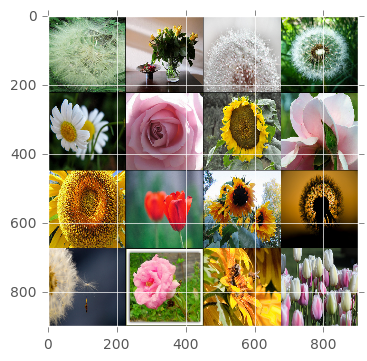

In [7]:
preds = vgg.model.predict(test_images)
for i in range(16):
    print("----------")
    print_prob(preds[i], vgg.classes)
show_images(test_images,(4,4))